# Workflow for Ensemble ResNet -- Image and Spectroscopy

### 06/2023
### Yongtao Liu

#### 

### Install and Import

In [2]:
import os
import win32com.client
import numpy as np
import time
import h5py
import sidpy
import pyNSID
import matplotlib.pyplot as plt
from tqdm import tqdm
import atomai as aoi

from scipy.ndimage import gaussian_filter
from IPython.display import clear_output
from skimage.morphology import skeletonize
from sklearn.metrics import euclidean_distances


# import acquition.py
from Acquisition_v0_6 import Acquisition   # include the Acquistion_v0.py in the same directory

### Start BEPyAE.exe and set VI

* Start BEPyAE.ext
* Set VI of BEPyAE; if this version includes PyScanner, also set VIs for PyScanner

In [2]:
newexp = Acquisition(exe_path = r"G:\My Drive\AE\PyAE\BEPyAE 060123 01\BEPyAE.exe")   # exe_path is the directory of BEPyAE; 

### Initialize Igor AR18
* Set offline development
* Build a connection between BEPyAE and AR18
* Get parameters in AR18

In [3]:
newexp.init_BEPyAE(offline_development = True) # set offline_development=True if doing offline development
                                                # executing this will also initlize AR18

>##### Hereinafter 
> * If no parameters are provided in a function, executing the function will utilize the default parameters within $BEPyAE.exe$.
> * Certain functions provide feedback after execution, which can be disabled by setting $feedbackon=False$. This allows you to deactivate feedback during specific iterations or instances when it is not required.
> * Note: For tip locations, -1 corresponds to the left-hand side on the x-axis and the bottom side on the y-axis, while 1 corresponds to the right-hand side on the x-axis and the top side on the y-axis.

### Set tip parameters
* set setpoint, tip locations

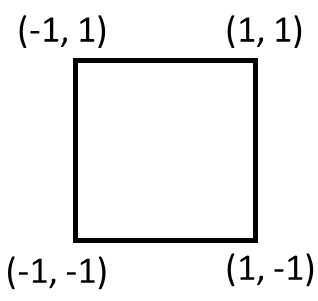

In [4]:
newexp.tip_control(tip_parms_dict = {"set_point_V_00": 1, "next_x_pos_00": -0.5, "next_y_pos_01": 0.5},
                   do_move_tip = True, 
                   do_set_setpoint = True) # Executing this code will set setpoint to 1 V, 
                                           # and move tip to location [0.5, 0.5]

Setpoint is:  1.0
Tip parameters are:  (-0.5, 0.5, 0.5)
Please reset if some parameters are incorrect


### Set IO 
This defines IO parameters, such as AFM platform: AR18, amplifiers, channel data types, etc

In [5]:
newexp.define_io_cluster(IO_cluster_parms_dict = {"analog_output_amplifier_06": 1, 
                                                  "channel_01_type_07": 1, 
                                                  "channel_02_type_08": 2,"channel_03_type_09": 3,})

IO control parameters are:  ('0 Cypher AR18', '6124', 4000000.0, 10.0, 10.0, 'AC and DC on AO0', 10.0, 'topography', 'current', 'aux', 'external')
Please reset if some parameters are incorrect


### Set BE pulse parameters 

In [6]:
# set BE parameters
newexp.define_be_parms(be_parms_dict = {"center_frequency_Hz_00": 335, "band_width_Hz_01": 100,
                                       "amplitude_V_02": 1, "phase_variation_03": 1,
                                       "repeats_04": 4, "req_pulse_duration_s_05": 4,
                                       "auto_smooth_ring_06": 1}, 
                      do_create_be_waveform = True)

BE parameters are:  (335000.0, 100000.0, 1.0, 1.0, 4, 0.004, 1, 3352.2952763920002, 0.12159459061880915)
Please reset if some parameters are incorrect


(335000.0,
 100000.0,
 1.0,
 1.0,
 4,
 0.004,
 1,
 3352.2952763920002,
 0.12159459061880915)

# *Run a Few Tests Before Experiment*
# --------------------------------------------------------

### BE Line scan
* This is a single BE line scan
* This returns 5 datasets: quick_fitting, complex spectra, and 3 channels

In [7]:
# Do a single line scan
qk_fit, com_spec, chn1, chn2, chn3 = newexp.do_line_scan(line_scan_parms_dict = {"num_BE_pulses_01": 32,
                                                                                 "start_x_pos_00": -0.5, "start_y_pos_01": 0,
                                                                                 "stop_x_pos_02": 0.5, "stop_y_pos_03": 0},
                                                         upload_to_daq = True, do_line_scan = True)

voltage offset and number of BE pulse are:  (0.0, 32)
line scan start and end positions:  (-0.5, 0.0, 0.5, 0.0)


### BE Raster Scan
* Square raster scan
* raster_scan returns 3 sidpy datasets: BEPFM quick fitting, channels, and BE complex spectra
* raster_scan also saves these 3 sidpy dataset in a hdf5 file

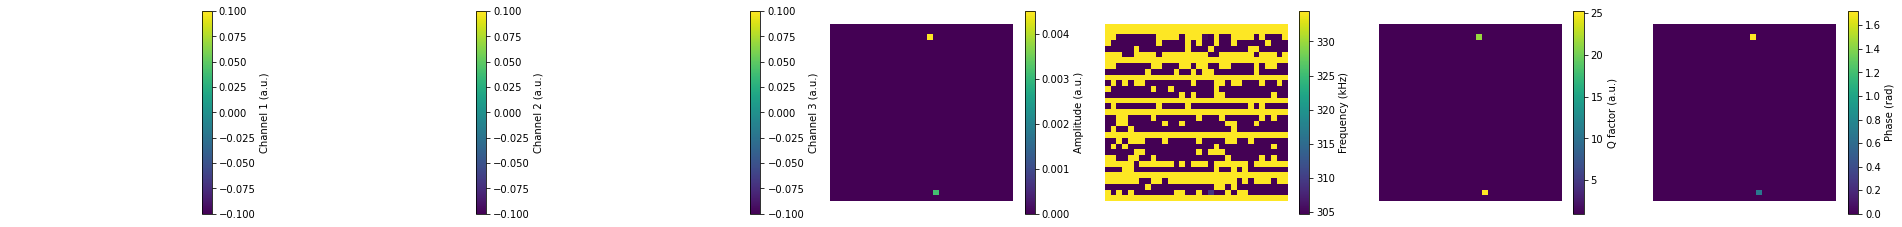

 [progress: 0:00:41] |************************************  | (ETA:   0:00:01) C:\Users\yla\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


In [8]:
# Do a 64*64 raster scan
dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"scan_pixel": 32, "scan_x_start": -0.8,
                                                                       "scan_y_start": -0.8,"scan_x_stop": 0.8,
                                                                       "scan_y_stop": 0.8}, 
                                                  file_name = "pfm")

# if you see below error, check if you set IO channels manually---this has to be done manually now
 ### TypeError: When specifying values over which a parameter is varied, values should not be an empty array

### BE Raster Scan Results
* 1. BE quick fit

In [9]:
dset_pfm

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<array, shape=(32, 32, 5), dtype=float64, chunksize=(32, 32, 5), chunktype=numpy.ndarray>
 data contains: quick fit pfm (generic)
 and Dimensions: 
y axis:  y axis (m) of size (32,)
x axis:  x axis (m) of size (32,)
BE responses:  channels (generic) of size (5,)

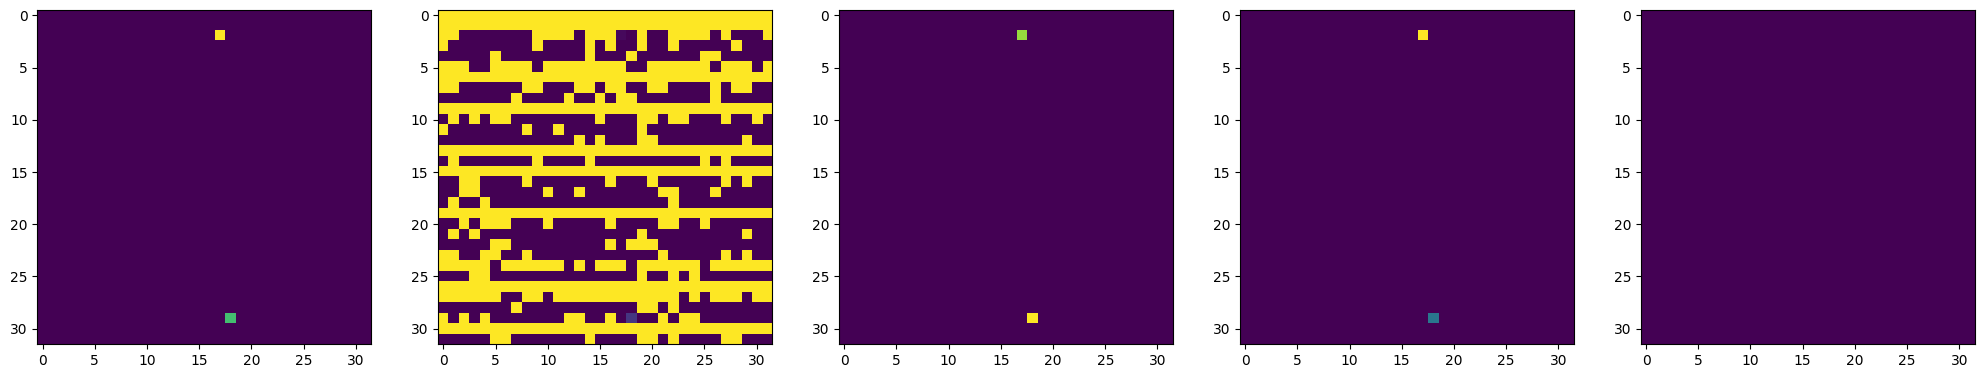

In [10]:
# plot BEPFM quick fit data
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (25, 5), dpi = 100)
ax1.imshow(dset_pfm[:,:,0])
ax2.imshow(dset_pfm[:,:,1])
ax3.imshow(dset_pfm[:,:,2])
ax4.imshow(dset_pfm[:,:,3])
ax5.imshow(dset_pfm[:,:,4])

* 2. channels

In [11]:
dset_chns

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<array, shape=(3, 32, 32, 1), dtype=float64, chunksize=(3, 32, 32, 1), chunktype=numpy.ndarray>
 data contains: channels (generic)
 and Dimensions: 
y axis:  y axis (m) of size (3,)
x axis:  x axis (m) of size (32,)
channels images:  channels (generic) of size (32,)
d:  generic (generic) of size (1,)

C:\Users\yla\Anaconda3\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\yla\Anaconda3\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\yla\Anaconda3\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


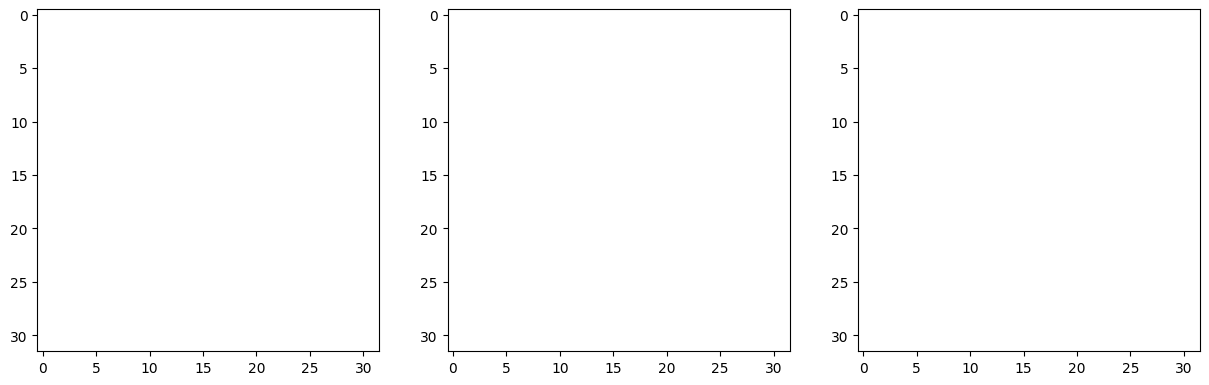

In [12]:
# plot channel data
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5), dpi = 100)
ax1.imshow(dset_chns[0,:,:])
ax2.imshow(dset_chns[1,:,:])
ax3.imshow(dset_chns[2,:,:])

* 3. complex spectra

In [13]:
# complex spectra
dset_cs

sidpy.Dataset of type UNKNOWN with:
 dask.array<array, shape=(32, 32, 62), dtype=complex128, chunksize=(32, 32, 62), chunktype=numpy.ndarray>
 data contains: pfm complex spectra (V)
 and Dimensions: 
location index y:  index (generic) of size (32,)
location index x:  index (Hz) of size (32,)
c:  generic (generic) of size (62,)

In [14]:
hf = h5py.File('pfm_0.hf5', 'r+')
sidpy.hdf.hdf_utils.print_tree(hf)

/
├ BE Channels
  -----------
  ├ Channels
    --------
    ├ Channels
    ├ channels images
    ├ d
    ├ x axis
    ├ y axis
├ BE Complex Spectra
  ------------------
  ├ Complex Spectra
    ---------------
    ├ Complex Spectra
    ├ c
    ├ location index x
    ├ location index y
├ BE Parameters
  -------------
  ├ frequency
  ├ pulse parameters
  ├ scan size
├ BE Quick Fitting
  ----------------
  ├ Quick Fitting
    -------------
    ├ BE responses
    ├ Quick Fitting
    ├ x axis
    ├ y axis


# *Tests Done*
# --------------------------------------------------------

# Experiment Starts

### Prior to expeirment, set a directory for saving data

In [15]:
os.chdir("/content/save directory/")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/save directory/'

### Step 1. Perform an image measurement, e.g., BEPFM 

In [16]:
dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"scan_pixel": 256, "scan_x_start": -1.0,
                                                                       "scan_y_start": -1.0,"scan_x_stop": 1.0,
                                                                       "scan_y_stop": 1.0}, file_name = "BEPFM")

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (30, 5), dpi = 100)
ax1.imshow(dset_pfm[:,:,0])
ax2.imshow(dset_pfm[:,:,1])
ax3.imshow(dset_pfm[:,:,2])
ax4.imshow(dset_pfm[:,:,3])
ax5.imshow(dset_chns[0,:,:])
ax6.imshow(dset_chns[1,:,:])
plt.show()

20 locations are ready for experiments


### Step 2. Pick the image channel involving the target objects

In [ ]:
# Load target image
target_raw = dset_pfm[:,:,0]
target_raw = np.copy(target_raw)
# normalize target_img
target_raw = (target_raw-target_raw.min())/(target_raw.ptp())

### Step 3. Pre-trained ResNet idenfies target objects

In [ ]:
# Load pre-trained ResNet weights
smodel, ensemble= aoi.models.load_ensemble("MHP_Grainboundry_ensemble_metadict.tar")

# Prediction
predictor = aoi.predictors.EnsemblePredictor(smodel, ensemble, nb_classes=1)
pred_mean, pred_var = predictor.predict(obtained_amp)
target_object = pred_mean.squeeze()
target_uncertainty = pred_var.squeeze()
    
# Plot prediction and uncertainty
f,(ax0, ax1, ax2) = plt.subplots(1, 3, dpi = 100)
ax0.imshow(target_img)
ax0.axis ('off')
ax0.set_title('Raw Image')
ax1.imshow(target_object, cmap = 'gray')
ax1.axis('off')
ax1.set_title('Prediction')
ax2.imshow(target_uncertainty, cmap = 'gray')
ax2.axis('off')
ax2.set_title('Uncertainty')
plt.show()

### Step 4. Extract coordinates of target objects

In [ ]:
# convert the target object image to a binary image
_, target_object_binary = cv2.threshold(target_object, 0.4, 1, cv2.THRESH_BINARY)
# skeletonzie the lines to avoide duplicated coordinates corresponding to the same object
target_object_img = skeletonize(target_object_binary==1)

# plot binary image and skeletonize image
_, (ax1, ax2) = plt.subplots(1, 2, dpi = 100)
ax1.imshow(target_object_binary, origin = 'lower')
ax1.set_title("Binary")
ax1.set_axis("off")
ax2.imshow(target_object_img, origin = 'lower')
ax2.set_title("Skeletonize")
ax2.set_axis("off")

In [ ]:
# Obtain all target coordinates
target_coordinates = np.asarray(np.where(target_object_img==1)).T 

# Rearange the coordinates to make the route along the object
# start at the default first location, ususally this is the lcoation near the bottom left corner
current_location = np.zeros((1,2))
current_location[:,] = target_coordinates[0,] 

pristine_route = np.copy(target_coordinates[1:,])
new_route = np.copy(current_location)

while len(pristine_route) != 0:  # Iterate until move all coordiantes in prisinte route to new route
    dist = euclidean_distances(current_location,pristine_route) 
    next_location = np.asarray(np.where(dist==dist.min())) # The next location is the one closest to the current location
    current_location [:,] = route[next_location[-1][-1]] # Update current location as the next location
    new_route = np.append (new_route, current_location, 0) # Append next location to the new route
    pristine_route = np.delete(pristine_route, next_loccation[:][1], 0) # Remove this locaiton from the prinstine route
  
## Plot the new route
plt.figure(dpi = 100)
c = np.arange (len(new_route[:,0]))
plt.scatter(new_route[:,1], new_route[:,0], c = c, cmap = "jet")
plt.show()
print("Total locations are: ", len(new_route[:,0]))

In [ ]:
# In some cases, it is not necessary to measure all target locations, so we can skip some.
skip_every = 5
skip_index = np.arange(0, len(new_route[:,0]), skip_every)  
measure_coordinates = new_route[skip_index]  # skip every 'skip_every' step to create a measurement coordiantes 

plt.figure(dpi = 100)
c = np.arange(len(measure_coordinates[:,0]))
plt.scatter(measure_coordinates[:,1], measure_coordinates[:,0], c = c, cmap = "jet")
plt.show()
print ("Total measurement locations are: ", len(measure_coordinates[:,0]))

### Step 5. Perform pre-planned measurements (e.g., BEPS) at target locations

In [ ]:
# Convert image coordinates to parameters for probe location
measure_locations = newexp.convert_coordinates(measure_coordinates)

In [ ]:
measure_steps = len(measure_coordinates[:,0])

for i in tqdm(range (measure_steps)):
    print("Step {}/{}".format(i, measure_steps))
    
    # Measurement location
    next_coordinate = measure_locations[i]
    
    # Do measurement
    newexp.do_beps(measure_locations)
    clear_output()

### Step 6. Save all results as an h5 file

In [ ]:
hf = h5py.File("Processing_Result", 'a')
hf['Images/Raw'] = np.asarray(target_raw)
hf['Images/Prediction'] = np.asarray(target_object)
hf['Images/Uncertainty'] = np.asarray(target_uncertainty)
hf['Images/Binary Object'] = np.asarray(object_binary)
hf['Images/Skeletonize Object'] = np.asarray(target_object_img)
hf['Coordinates/Target'] = np.asarray(target_coordinates)
hf['Coordinates/Rearange'] = np.asarray(new_route)
hf['Coordinates/Measure'] = np.asarray(measure_coordinates)
hf['Coordinates/Convert'] = np.asarray(measure_locations)